## Racist Deeds Proof of Concept

### Step 1: Extracting Ground Truth Text

This steps assumes you have two directories in the same directory as this notebook:
- ./racist_deeds_text
- ./non_racist_deeds_text

You can access the racist deeds text [here](https://drive.google.com/drive/folders/1bo3TJqgnqVh4MsmqCGEjeH_ms9QbRoCf?usp=drive_link).
You can access the non-racist deeds text [here](https://drive.google.com/drive/folders/10EEBMFT63pTTlpGvVr_Se-XN2Dvl1hHs?usp=drive_link)

Run the following script to extract the deed text into a dataframe with a column for is_racist:

In [2]:
import os
import pandas as pd
from pathlib import Path
import sys
sys.path.append('../deed_preprocessing')
from preprocessor import preprocess_text
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def preprocess_deeds():
    sys.path.append('../deed_preprocessing')
    from preprocessor import preprocess_text

    racist_dir = Path('./racist_deeds_text')
    non_racist_dir = Path('./non_racist_deeds_text')

    all_data = pd.DataFrame()

    racist_count = 0
    non_racist_count = 0

    def process_directory(directory, is_racist_label):
        nonlocal all_data, racist_count, non_racist_count
        for file in directory.iterdir():
            if file.is_file() and file.suffix == '.txt':
                with file.open('r', encoding='utf-8') as f:
                    text = f.read()
                    processed_text = preprocess_text(text)

                    df = pd.DataFrame([processed_text])
                    df['is_racist'] = is_racist_label

                    all_data = pd.concat([all_data, df], ignore_index=True)

                if is_racist_label == 1:
                    racist_count += 1
                else:
                    non_racist_count += 1

    process_directory(racist_dir, 1)
    process_directory(non_racist_dir, 0)

    print(f"Number of racist text files read: {racist_count}")
    print(f"Number of non-racist text files read: {non_racist_count}")

    return all_data


preprocessed_data = preprocess_deeds()
preprocessed_data.to_pickle('preprocessed_deeds.pkl')

Number of racist text files read: 61
Number of non-racist text files read: 750


### Step 2: Establishing a Baseline with Bag of Words and Logistic Regression

The following code runs bag of words and logistic regression on the ground truth dataset of 750 non-racist deeds, and 61 racist deeds.

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       1.00      1.00      1.00        16

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244



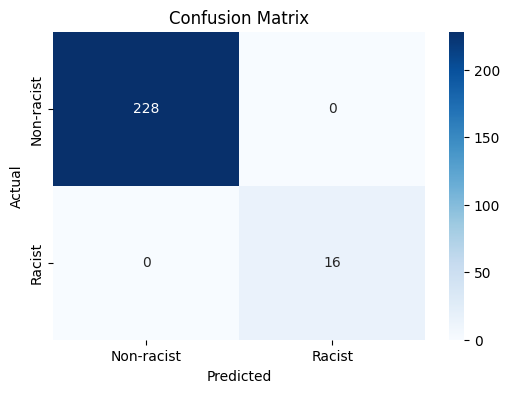

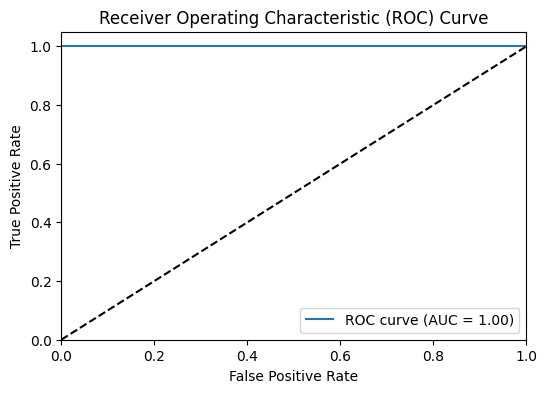

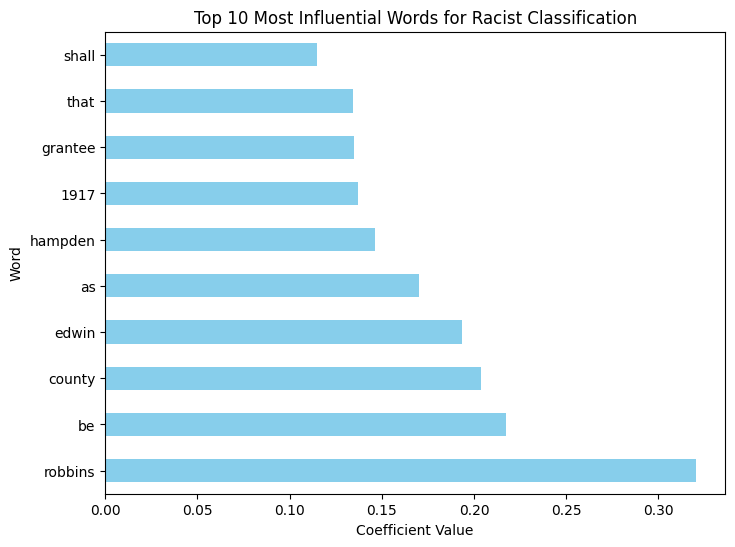

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_bag_of_words(preprocessed_text_list):
    texts = [preprocessed["original_text"] for preprocessed in preprocessed_text_list]
    
    vectorizer = CountVectorizer()
    bag_of_words = vectorizer.fit_transform(texts)

    bow_df = pd.DataFrame(bag_of_words.toarray(), columns=vectorizer.get_feature_names_out())

    return bow_df, vectorizer

preprocessed_data = pd.read_pickle('preprocessed_deeds.pkl')

texts = preprocessed_data['original_text']
preprocessed_text_list = texts.apply(lambda x: {"original_text": x}).tolist()

bow_df, vectorizer = preprocess_bag_of_words(preprocessed_text_list)

X = bow_df
y = preprocessed_data['is_racist']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-racist', 'Racist'], yticklabels=['Non-racist', 'Racist'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_prob = logistic_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

feature_importance = pd.Series(logistic_model.coef_[0], index=vectorizer.get_feature_names_out())
top_features = feature_importance.nlargest(10)

plt.figure(figsize=(8, 6))
top_features.plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Influential Words for Racist Classification')
plt.xlabel('Coefficient Value')
plt.ylabel('Word')
plt.show()


As shown in the graphs, a simple bag of words and logistic regression model achieves 100% accuracy on the ground truth data we have. Upon further examination, we can see that the model is using the name of a grantor, Edwin Robbins of Hampden County, to categorize a deed as racist or otherwise. It just so happens that all the deeds in our ground truth were issued by Edwin Robbins and contained racist language. It is interesting that we can attribute all these racist deeds to a single person, but the model will generalize poorly, so we will need to engineer features to circumvent this issue.